# About this notebook
#### In this notebook i will try to make a **comparison** between building and training a **nerual network from scratch** and using **Transfer learning(pretrained model)**, in terms of **trainig time, ease of creation, accuracy and consistancy**
#### This notebook was intented to be just a self trial to test the results, but i saw that it might help others so i tried to add insights and some references that might help

## Importing libraries

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import visualkeras
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from PIL import Image

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# TensorFlow pipeline
We will create a dataset pipeline from our data using tensorflow dataset api

TensorFlow has a dataset api that supports writing descriptive and efficient input pipelines. a common pattern is to
- Create a source dataset from your input data.
- Apply dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.

[For more information](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

## Making a balance dataset using data augmentation

### Find outlier images using IsolationForset method

In [45]:
# from sklearn.ensemble import IsolationForest

# def load_images_from_folder(folder, desired_width, desired_height):
#     images = []
#     for filename in os.listdir(folder):
#         img_path = os.path.join(folder, filename)
#         img = Image.open(img_path)
#         img = img.resize((desired_width, desired_height))  # Resize the image if needed
#         img = np.array(img)
#         images.append(img)
#     return images

# def find_outlier_images(images):
#     # Flatten the images
#     flattened_images = np.array(images).reshape(len(images), -1)

#     # Fit the Isolation Forest model
#     model = IsolationForest(contamination='auto')
#     model.fit(flattened_images)

#     # Predict outliers
#     outlier_indices = model.predict(flattened_images)
#     outlier_images = [images[i] for i in range(len(images)) if outlier_indices[i] == -1]

#     return outlier_images

# # Set the path to your image folder
# image_folder = "E:\\augmented\\TSLN"

# # Set the desired width and height for resizing the images
# desired_width = 224
# desired_height = 224

# # Load images from the folder
# images = load_images_from_folder(image_folder, desired_width, desired_height)

# # Find outlier images using Isolation Forest
# outlier_images = find_outlier_images(images)

# # Calculate the number of rows and columns for subplots
# num_images = len(outlier_images)
# num_rows = (num_images + 2) // 3
# num_cols = min(num_images, 3)

# # Set the figure size based on the number of images
# fig_width = 4 * num_cols
# fig_height = 4 * num_rows

# # Create the subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
# fig.tight_layout(pad=2.0)

# # Flatten the axs array if only one row or column
# if num_rows == 1:
#     axs = axs.reshape(-1)
# if num_cols == 1:
#     axs = axs.reshape(-1)

# # Display the outlier images
# for i, (img, filename) in enumerate(zip(outlier_images, os.listdir(image_folder))):
#     row = i // num_cols
#     col = i % num_cols
#     axs[row, col].imshow(img)
#     axs[row, col].axis('off')
#     axs[row, col].set_title(filename)  # Set the title to the file name

# plt.show()

### Save only non outliers image to the folder

In [46]:
# # Create a list of non-outlier images
# non_outlier_images = [img for img in images if tuple(img.flatten()) not in [tuple(out_img.flatten()) for out_img in outlier_images]]

# # Set the path to the new folder for saving non-outlier images
# non_outlier_folder = "E:\\clean_data_TSLN\\TSLN"

# # Create the new folder if it doesn't exist
# if not os.path.exists(non_outlier_folder):
#     os.makedirs(non_outlier_folder)

# # Save non-outlier images to the new folder
# for i, img in enumerate(non_outlier_images):
#     filename = f"non_outlier_{i}.png"  # You can customize the filename
#     save_path = os.path.join(non_outlier_folder, filename)
#     non_outlier_img = Image.fromarray(img)
#     non_outlier_img.save(save_path)

### data augmentation for each class to make it balance

In [47]:
# # # Directory containing your dataset
# data_directory = 'C:\\Users\\jackaquamin\\Downloads\\Coding\\11'

# # Directory to save augmented images
# augmented_directory = 'E:\\clean-augment'

# # Parameters for data loading
# batch_size = 64
# image_size = (224, 224)

# def custom_preprocessing(image):
#     from skimage import exposure
#     image = exposure.rescale_intensity(image, in_range=(0, 255))
#     return image

# # Create an ImageDataGenerator instance with augmentation settings
# data_generator = ImageDataGenerator(
#     rescale=1.0 / 255,
#     rotation_range=360,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     preprocessing_function=custom_preprocessing,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

# # Load the dataset using flow_from_directory
# train_dataset = data_generator.flow_from_directory(
#     data_directory,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=True,
#     seed=2022
# )

# # Function to generate augmented images and save them to the augmented directory
# def generate_augmented_images_for_class(class_label, image_generator, num_augmented_images=10):
#     class_dir = os.path.join(augmented_directory, class_label)
#     if not os.path.exists(class_dir):
#         os.makedirs(class_dir)
        
#     class_images = os.listdir(os.path.join(data_directory, class_label))
#     for image_name in class_images:
#         image_path = os.path.join(data_directory, class_label, image_name)
#         img = load_and_preprocess_image(image_path, image_size)
#         img_batch = np.repeat(img, num_augmented_images, axis=0)  # Repeat image for batch
            
#         original_filename, _ = os.path.splitext(image_name)
#         i = 0
#         for batch in image_generator.flow(img_batch, batch_size=num_augmented_images,
#                                           save_to_dir=class_dir,
#                                           save_prefix=f'{class_label}_{original_filename}',
#                                           save_format='png'):
#             i += 1
#             if i >= 1:  # Only one batch of augmented images is generated
#                 break

# # Load and preprocess an image
# def load_and_preprocess_image(image_path, target_size):
#     img = Image.open(image_path)
#     img = img.resize(target_size)
#     img = np.array(img)
#     img = img.reshape((1,) + img.shape)
#     img = img / 255.0  # Rescale pixel values between 0 and 1
#     return img

# # Generate augmented images and save them to the augmented directory
# generate_augmented_images_for_class("TSLN", data_generator, num_augmented_images=4)

In [48]:
# generating dataset from directory
# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = 'E:\\clean-augment',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 12026 files belonging to 11 classes.


In [49]:
labels = np.concatenate([y for x,y in data], axis=0)

In [50]:
values = pd.value_counts(labels)
values = values.sort_index()
values

0     1088
1     1056
2     1086
3     1064
4     1203
5     1064
6     1041
7     1092
8     1080
9     1178
10    1074
dtype: int64

In [51]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = ARMD, 1 = BRVO, 2 = DN, 3 = DR, 4 = MH, 5 = MYA, 6 = ODC, 7 = ODE, 8 = ODP, 9 = TSLN, 10 = normal, 

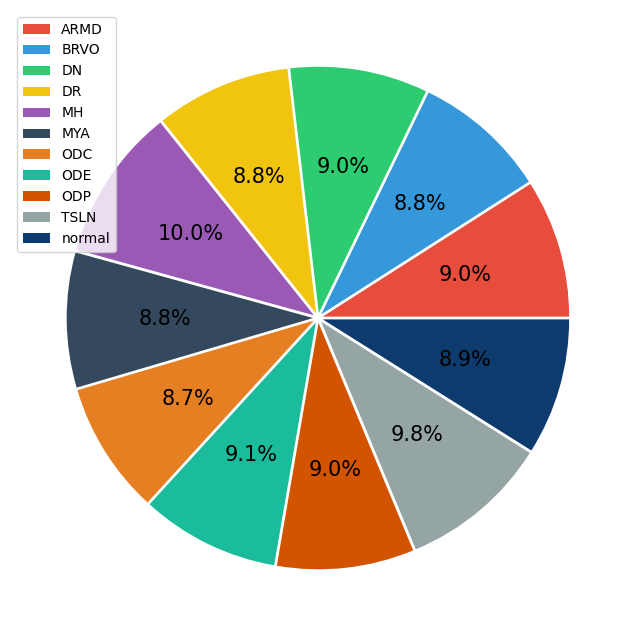

In [52]:
# plt.figure(figsize=(12,8))
# plt.pie(values,autopct='%1.1f%%', explode = [0.02,0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02], textprops = {"fontsize":15})
# plt.legend(labels=data.class_names)
# plt.show()

# Custom colors for each class
custom_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6', '#34495E', '#E67E22', '#1ABC9C', '#D35400', '#95A5A6', '#0D3B6E']

plt.figure(figsize=(12, 8))
plt.pie(values, autopct='%1.1f%%', explode=[0.02] * 11, textprops={"fontsize": 15}, colors=custom_colors)
plt.legend(labels=data.class_names)
plt.show()

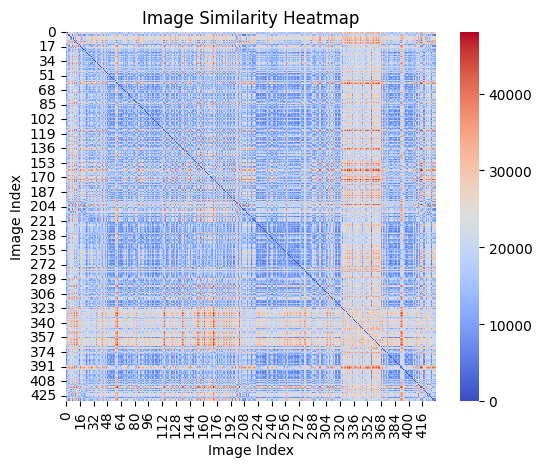

In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics.pairwise import pairwise_distances

def load_images_from_folder(folder, desired_width, desired_height):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img = img.resize((desired_width, desired_height))  # Resize the image if needed
        img = np.array(img)
        images.append(img)
    return images

def plot_similarity_heatmap(images):
    # Compute similarity matrix
    flattened_images = np.array(images).reshape(len(images), -1)
    similarity_matrix = pairwise_distances(flattened_images, metric='euclidean')

    # Plot similarity matrix as heatmap
    sns.heatmap(similarity_matrix, cmap='coolwarm', square=True)
    plt.title('Image Similarity Heatmap')
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.show()

# Set the path to your image folder
image_folder = "C:\\Users\\jackaquamin\\Downloads\\FundusOG\\non_outliers\\MH"

# Set the desired width and height for resizing the images
desired_width = 224
desired_height = 224

# Load images from the folder
images = load_images_from_folder(image_folder, desired_width, desired_height)

# Plot similarity heatmap
plot_similarity_heatmap(images)

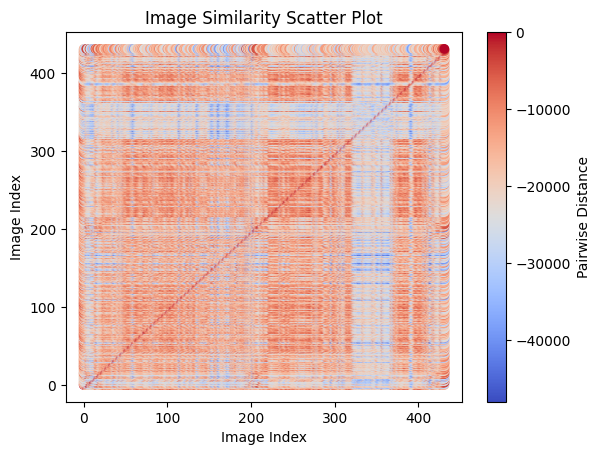

In [54]:
def load_images_from_folder(folder, desired_width, desired_height):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img = img.resize((desired_width, desired_height))  # Resize the image if needed
        img = np.array(img)
        images.append(img)
    return images

def plot_similarity_scatter(images):
    # Compute similarity matrix
    flattened_images = np.array(images).reshape(len(images), -1)
    similarity_matrix = pairwise_distances(flattened_images, metric='euclidean')

    # Convert similarity matrix to pairwise distances
    distances = 1 - similarity_matrix

    # Plot scatter plot
    x, y = np.meshgrid(range(distances.shape[0]), range(distances.shape[1]))
    plt.scatter(x.flatten(), y.flatten(), c=distances.flatten(), cmap='coolwarm')
    plt.colorbar(label='Pairwise Distance')
    plt.title('Image Similarity Scatter Plot')
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.show()

# Set the path to your image folder
image_folder = "C:\\Users\\jackaquamin\\Downloads\\FundusOG\\non_outliers\\MH"

# Set the desired width and height for resizing the images
desired_width = 224
desired_height = 224

# Load images from the folder
images = load_images_from_folder(image_folder, desired_width, desired_height)

# Plot similarity scatter plot
plot_similarity_scatter(images)

#less pairwise distance, the more similarity

## Getting a data generator to explore the data

In [55]:
data_iterator = data.as_numpy_iterator()

In [56]:
batch = data_iterator.next()

### Each batch contains 64 images, each image is 224x224

In [57]:
batch[0].shape

(64, 224, 224, 3)

## Displaying some images

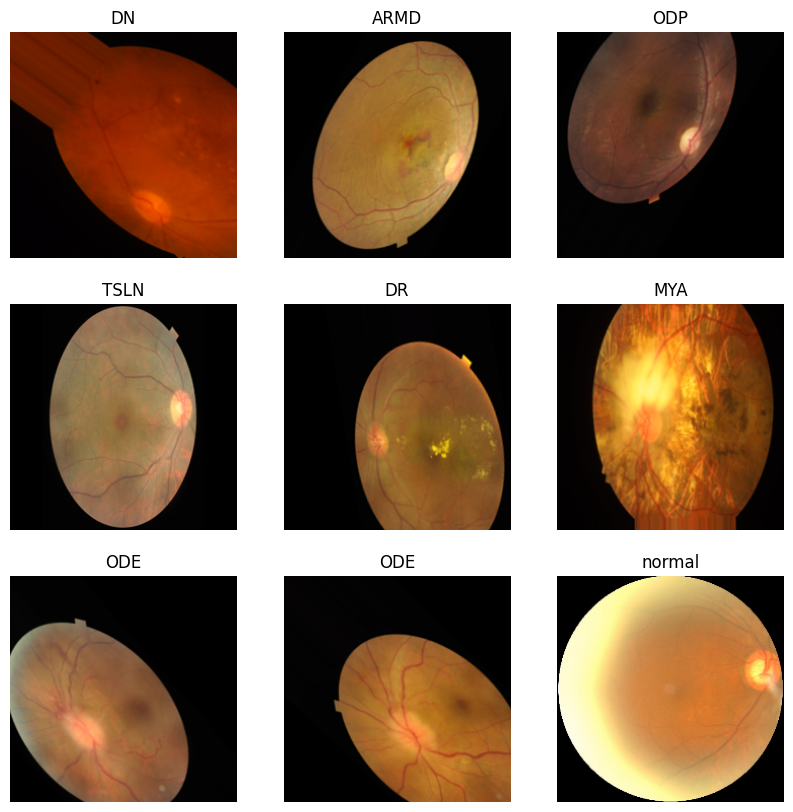

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

-----------
# Preprocessing images

## Standardize the data
Standardizing the data in image classification refers to the process of transforming the pixel values of images so that they have a mean of 0 and a standard deviation of 1. This normalization technique is also known as "Z-score normalization" or "standard score normalization." Standardization makes the data more amenable for training machine learning models, particularly neural networks, by ensuring that the features have similar scales and distributions.

In [59]:
data = data.map(lambda x, y: (x/255, y))

In [60]:
sample = data.as_numpy_iterator().next()

In [61]:
print(sample[0].min())
print(sample[0].max())

0.0
1.0


## Spliting the data

In [62]:
print("Total number of batchs = ",len(data))

Total number of batchs =  188


In [63]:
train_size = int(0.8 * len(data)) +1
val_size = int(0.1 * len(data))
test_size = int(0.1 * len(data))

In [64]:
#train = data.take(train_size)
#remaining = data.skip(train_size)
#val = remaining.take(val_size)
#test = remaining.skip(val_size)

In [65]:
#print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
#len(train) + len(val) + len(test)

## Preparing test set

In [66]:
#test_iter = test.as_numpy_iterator()

In [67]:
#test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
#while True:
#  try:
#    batch = test_iter.next()
#    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
#    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
#  except:
#    break

In [68]:
data = data.shuffle(buffer_size=len(data), seed=2022, reshuffle_each_iteration=False)

In [69]:
kf = KFold(n_splits=10)
fold = 0

In [70]:
for train_index, val_index in kf.split(np.arange(len(data))):
    fold += 1
    print(f"Fold: {fold}")
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size)

    test_iter = test.as_numpy_iterator()

    test_set = {"images": np.empty((0, 224, 224, 3)), "labels": np.empty(0)}
    while True:
        try:
            batch = test_iter.next()
            test_set['images'] = np.concatenate((test_set['images'], batch[0]))
            test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
        except:
            break

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


In [71]:
y_true = test_set['labels']

------------
# CNN from scratch

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [73]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

-----------
# Transfer Learning (Pretrained Model)
#### **Here i will try to use a pretraind model, finetune it to fit our data, you can read [more about transfer learning here](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)**
#### **I used [EfficientNet](https://paperswithcode.com/method/efficientnet) pretrained model, because the data it was trained on is different from our data, i made the top level layers trainable to allow it to train, fit and adapt with our data**

In [74]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import h5py
def make_model():
    mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')
    mobilenet.trainable = False

    
    for layer in mobilenet.layers[83:]:
      layer.trainable=True
    
    x = mobilenet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(11, activation='softmax')(x)
    
    model= tf.keras.Model(inputs=mobilenet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [75]:
model = make_model()

In [76]:
model.summary()

# visualkeras.layered_view(model,legend=True)

# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# plot_model(model, to_file='C:\\Users\\jackaquamin\\Downloads\\SeniorProject\\model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

## Train the Model

In [77]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=20,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 200,
    callbacks=[early_stop],
)

Epoch 1/200
151/151 [==============================] - 82s 491ms/step - loss: 14.8532 - accuracy: 0.5023 - val_loss: 12.0362 - val_accuracy: 0.2005
Epoch 2/200
151/151 [==============================] - 53s 318ms/step - loss: 6.5033 - accuracy: 0.6671 - val_loss: 5.8760 - val_accuracy: 0.2717
Epoch 3/200
151/151 [==============================] - 54s 320ms/step - loss: 3.2156 - accuracy: 0.7390 - val_loss: 3.7202 - val_accuracy: 0.2752
Epoch 4/200
151/151 [==============================] - 54s 323ms/step - loss: 1.8334 - accuracy: 0.7949 - val_loss: 2.8171 - val_accuracy: 0.3255
Epoch 5/200
151/151 [==============================] - 54s 323ms/step - loss: 1.2442 - accuracy: 0.8258 - val_loss: 1.9158 - val_accuracy: 0.5495
Epoch 6/200
151/151 [==============================] - 54s 323ms/step - loss: 0.9677 - accuracy: 0.8579 - val_loss: 2.0017 - val_accuracy: 0.4644
Epoch 7/200
151/151 [==============================] - 55s 326ms/step - loss: 0.8478 - accuracy: 0.8636 - val_loss: 2.2085

In [85]:
model_path = 'C:\\Users\\jackaquamin\\Downloads\\Coding\\model\\model_senior.h5'
model.save(model_path)

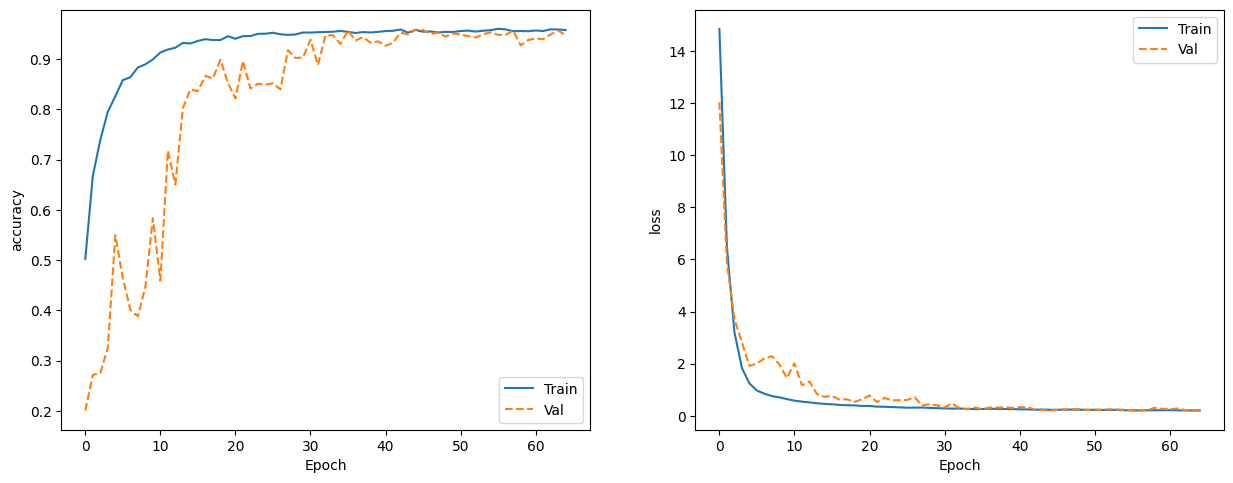

In [79]:
plot_his(history)

## Evaluating the model on test set

In [80]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

38/38 [==============================] - 4s 89ms/step


In [81]:
# Get the ground truth labels from 'test_set'
true_labels = test_set['labels']

# Calculate the accuracy
correct_predictions = np.sum(np.equal(y_pred, true_labels))
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions * 100

# Print the accuracy
print("Testing Accuracy:", accuracy, "%")

Testing Accuracy: 96.29934210526315 %


In [82]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

        ARMD       0.94      1.00      0.97       100
        BRVO       0.95      1.00      0.97       107
          DN       0.99      0.95      0.97       110
          DR       0.95      0.96      0.95       108
          MH       0.94      0.94      0.94       125
         MYA       0.99      0.96      0.97        97
         ODC       0.91      0.89      0.90       131
         ODE       1.00      1.00      1.00       109
         ODP       1.00      0.96      0.98       101
        TSLN       0.94      0.94      0.94       105
      normal       1.00      1.00      1.00       123

    accuracy                           0.96      1216
   macro avg       0.96      0.96      0.96      1216
weighted avg       0.96      0.96      0.96      1216



Text(0.5, 1.0, 'Confusion Matrix')

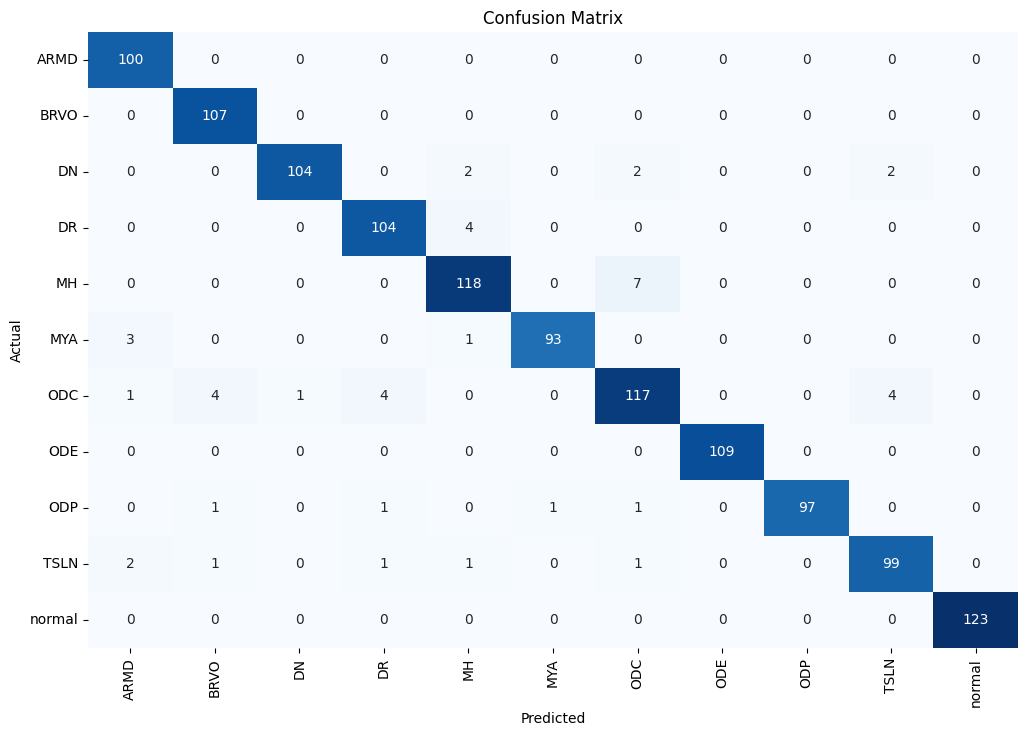

In [83]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(11)+.5, class_names, rotation=90)
plt.yticks(np.arange(11)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## **Insights**
- The model acheived 95% accuracy and f1-score on the test set
- The training has run for 50 epochs and did not stop by early stopping, although noticing the history plot i don't think it could achieve any higher
- Each Epoch took about 50 sec to execute 
- The validation loss curve looks very smooth and has no fluctuations

# Conclusion
It's very intersting how transfer learning can improve and satisfy our goals with higher accuracy, consistant and faster
- With pretraind model We achieved 93% with 7% improvment from our own Neural network 86%
- The training phase was more consistant and faster in the pretraind model
- Maybe the Neural network i built wasn't the best and could be improved a lot, but you can see how easy and efficient you can use a pretrained model without the headaches of building you own layer by layer and trying to tune it as much as you can and you may not end with better result or close to as the pretrained one

So consider from now on to benfit from the power of Transfer learning and give it a try before trying to build your own one, it may save you a lot.

In [86]:
import tensorflow.keras as keras

# load the model
model = keras.models.load_model('C:\\Users\\jackaquamin\\Downloads\\Coding\\model\\model_senior.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_senior.tflite', 'wb') as f:
    f.write(tflite_model) 

INFO:tensorflow:Assets written to: C:\Users\JACKAQ~1\AppData\Local\Temp\tmprdtg0w23\assets


INFO:tensorflow:Assets written to: C:\Users\JACKAQ~1\AppData\Local\Temp\tmprdtg0w23\assets
